<figure>
<IMG SRC="../../lectures/images/PhysicsLogo.jpg" WIDTH=100 ALIGN="right">
</figure>
# [Physics 411](http://jklymak.github.io/Phy411/) Time Series Analysis
*Jody Klymak*


# Assignment 5

## Q1: Distribution of power spectral estimates

<div style='background:#F0F0F0'>**1** You **may** use `matplotlib.mlab.psd` for the following question, but you had best use it correctly!

Using normally distributed random noise time series of length $N=2048$, show using a Monte Carlo analysis and by comparison to the theoretical probability distribution functions that:  
</div>

   1. The raw spectral estimate is indeed distributed as $\chi^2_2$.
   2. Show that block averaging with no overlap is distributed as $\chi^2_{2N_{blocks}}$.
   3. Show that block averaging with 50% overlap Hanning windows is distributed as $\chi^2_{2N_{blocks}}$.

<div style='background:#F0F0F0'>You can choose your block length, but making it an integer divisor of 2048 will make your life a lot easier.  Show that as $N_{blocks}$ is increased the variance drops (i.e. the distribution of the spectral estimates gets tighter).</div>


<div style='background:#F0F0F0'>HINT: for this time series the individual frequency estimates are indipendent samples of the distribution, so you can use them in compiling your distributions.</div>

<div style='background:#F0F0F0'>HINT: To get the pdf of the $\chi^2_\nu$ distribution correct, you need to "scale" by $\nu^{-1}$ where $\nu$ are the degrees of freedom.</div>

<div style='background:#F0F0F0'>HINT: for good presentation, make your histograms have the same bin sizes, and compare the distributions for all three cases on the same plot.</div>

In [1]:
import numpy.random as random
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats
%matplotlib nbagg
%matplotlib inline

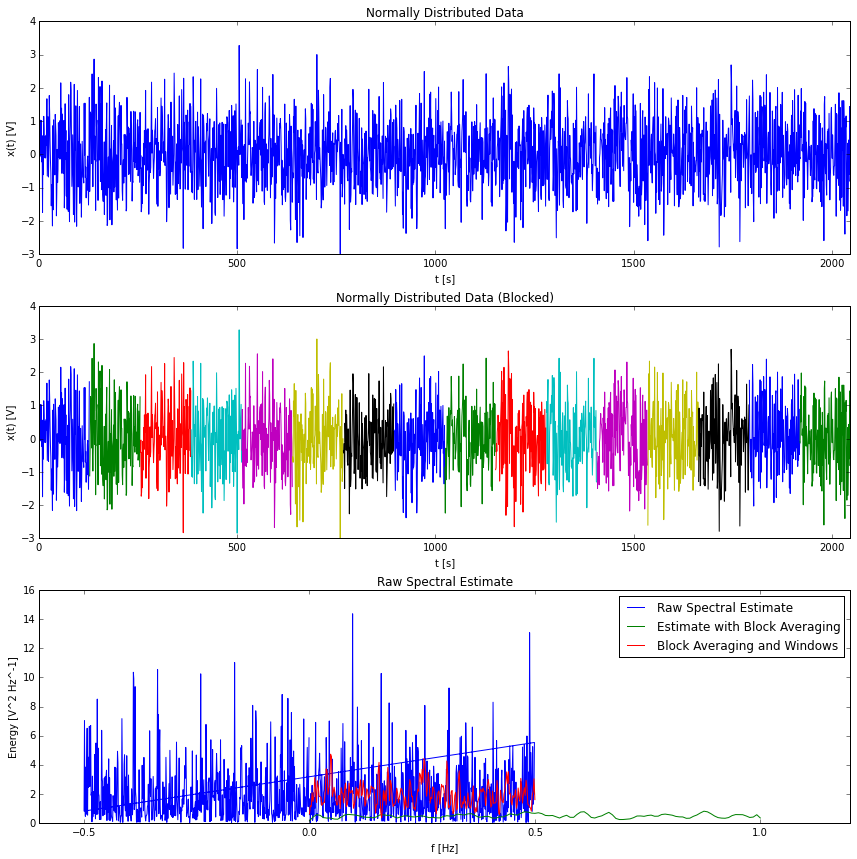

In [19]:
# Gather data
N = 2048
x = np.random.normal(0,1,N)
t = np.arange(N)
dt = 1 # hour
T = N*dt

# Raw spectral estimate
#raw,freqs = mlab.psd(x)
X = dt*np.fft.fft(x)
raw = (2./T)*np.real(np.conj(X[:N/2])*X[:N/2])
freqs = np.fft.fftfreq(len(raw),1.)
#print len(raw)

# Block averaging with no overlap
blockSize = 128
Nblocks = N/blockSize # 8

blockSpectrals = np.zeros((Nblocks,len(raw)))
blockFreqs = []

for ind in range(Nblocks):
    inds =range(ind*blockSize,(ind+1)*blockSize)
    tblock=t[inds]
    xblock=x[inds]
    spectral,blockFreqs = mlab.psd(xblock)
        
    if ind==0:
        blockSpectrals = np.zeros((Nblocks,len(spectral)))
        
    blockSpectrals[ind,:] = spectral
    #print blockFreqs
    
blockAve = np.mean(blockSpectrals,axis=0)

# Block averaging with 50% overlap Hanning windows
blockWindows,freqWindows = mlab.psd(x,NFFT=512,Fs=1./dt,window=mlab.window_hanning,noverlap=256)

# Graph the data before putting it in histograms
plt.figure(figsize=(12,12))
gs=gridspec.GridSpec(3,1)

# graph normal data
ax1=plt.subplot(gs[0:1])
ax1.plot(t,x,label='x(t)')
ax1.set_xlabel('t [s]')
ax1.set_ylabel('x(t) [V]')
ax1.set_title('Normally Distributed Data')
ax1.set_xlim(right=t[-1])

# graph blocked data
ax2=plt.subplot(gs[1:2])
for ind in range(Nblocks):
    inds =range(ind*blockSize,(ind+1)*blockSize)
    tblock=t[inds]
    xblock=x[inds]
    #print len(xblock)
    ax2.plot(tblock,xblock)
ax2.set_xlabel('t [s]')
ax2.set_ylabel('x(t) [V]')
ax2.set_title('Normally Distributed Data (Blocked)')
ax2.set_xlim(right=t[-1])

#print len(blockAve)
#print len(blockFreqs)

# graph spectral estimates
ax3=plt.subplot(gs[2:3])
ax3.plot(freqs,raw,label='Raw Spectral Estimate')
ax3.plot(blockFreqs,blockAve,label='Estimate with Block Averaging')
ax3.plot(freqWindows,blockWindows,label='Block Averaging and Windows')
ax3.set_xlabel('f [Hz]')
ax3.set_ylabel('Energy [V^2 Hz^-1]')
ax3.set_title('Raw Spectral Estimate')
ax3.legend()

plt.tight_layout()

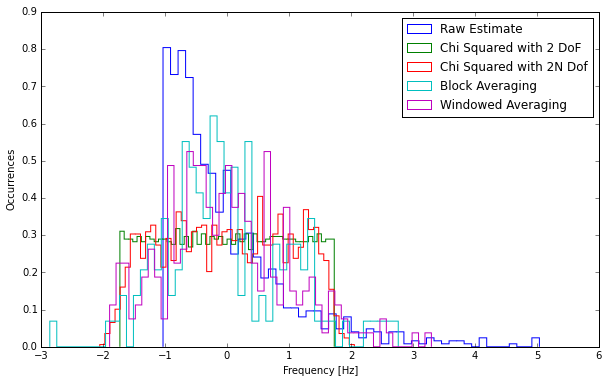

In [17]:
# Theoretical PDF's
#chiSquared2 = stats.chi2.pdf(x,2)
#chiSquared2N = stats.chi2.pdf(x,2*N)
chiSquared2 = np.arange(N)
for k in range(2):
    chiSquared2 += np.random.normal(0,1,N)**2
    
chiSquared2N = np.arange(N)
for k in range(2*N):
    chiSquared2N += np.random.normal(0,1,N)**2
    
df = freqs[-1]/len(freqs)
#chiSquared2 = stats.chi2(df,loc=0,scale=1)

# Normalize data
rawMean = np.mean(raw)
rawStd = np.std(raw)
rawNorm = (raw-rawMean)/rawStd
chiSquared2Mean = np.mean(chiSquared2)
chiSquared2Std = np.std(chiSquared2)
chiSquared2Norm = (chiSquared2-chiSquared2Mean)/chiSquared2Std
chiSquared2NMean = np.mean(chiSquared2N)
chiSquared2NStd = np.std(chiSquared2N)
chiSquared2NNorm = (chiSquared2N-chiSquared2NMean)/chiSquared2NStd
blockMean = np.mean(blockAve)
blockStd = np.std(blockAve)
blockNorm = (blockAve-blockMean)/blockStd
windowMean = np.mean(blockWindows)
windowStd = np.std(blockWindows)
windowNorm = (blockWindows-windowMean)/windowStd

# Plot Histograms Together
bins = 50

plt.figure(figsize=(10,6))
gs=gridspec.GridSpec(1,1)
ax=plt.subplot(gs[0:1])
ax.hist(rawNorm,bins,label='Raw Estimate',histtype='step',normed=True)
ax.hist(chiSquared2Norm,bins,label='Chi Squared with 2 DoF',histtype='step',normed=True)
ax.hist(chiSquared2NNorm,bins,label='Chi Squared with 2N Dof',histtype='step',normed=True)
ax.hist(blockNorm,bins,label='Block Averaging',histtype='step',normed=True)
ax.hist(windowNorm,bins,label='Windowed Averaging',histtype='step',normed=True)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Occurrences')
ax.legend()

YOUR ANSWER HERE

<div style='background:#F0F0F0'>**2**  For the Hanning window estimate, what fits better: $2N_{blocks}$ degrees of freedom or $18N_{blocks}/11$ degrees of freedom (the correct theoretical value)?  Its OK to evaluate by eye.</div>

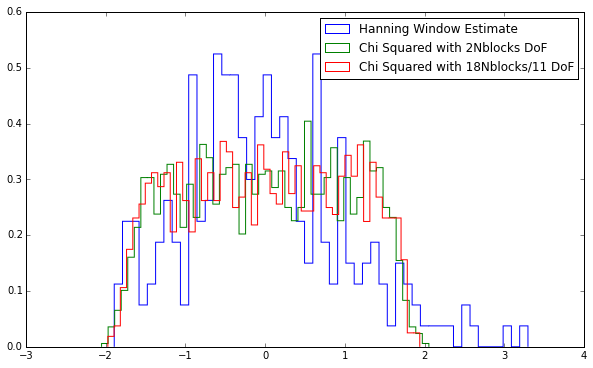

In [24]:
# Create 18Nblocks/11 pdf
chiSquared18N11 = np.arange(N)
for k in range(18*N/11):
    chiSquared18N11 += np.random.normal(0,1,N)**2
    
chiSquared18N11Mean = np.mean(chiSquared18N11)
chiSquared18N11Std = np.std(chiSquared18N11)
chiSquared18N11Norm = (chiSquared18N11-chiSquared18N11Mean)/chiSquared18N11Std

# Plot it
plt.figure(figsize=(10,6))
gs=gridspec.GridSpec(1,1)
ax=plt.subplot(gs[0:1])
ax.hist(windowNorm,bins,label='Hanning Window Estimate',histtype='step',normed=True)
ax.hist(chiSquared2NNorm,bins,label='Chi Squared with 2Nblocks DoF',histtype='step',normed=True)
ax.hist(chiSquared18N11Norm,bins,label='Chi Squared with 18Nblocks/11 DoF',histtype='step',normed=True)
ax.legend()

YOUR ANSWER HERE

## Q2: Spectra of a "red-noise" signal

<div style='background:#F0F0F0'> **1** Load in the Deep Cove hourly data, and compute the power spectra using some reasonable value for $N_{FFT}$, and comment on the effect of applying the Hanning window to not applying it to the spectral leakage.</div>

In [27]:
hourdata=np.genfromtxt('http://web.uvic.ca/~jklymak/Phy411/Data/AllHourly.txt')[[6,28],2:]
dc = hourdata[0,:]
dc=dc[np.isfinite(dc)]

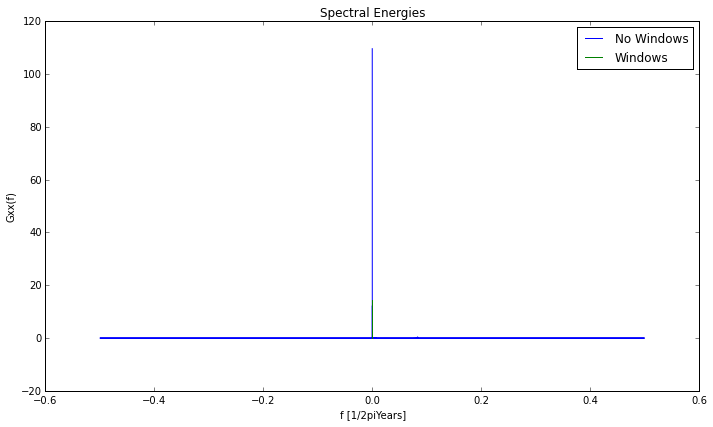

In [43]:
t = np.arange(len(dc))
N = len(dc)
dt = 60*60*24*365.25 # year
T = dt * N

# Raw Spectra
DC = dt*np.fft.fft(dc)
GxxDC= (2./T)*np.real(np.conj(DC[:N/2])*DC[:N/2])
freqGxxDC = np.fft.fftfreq(len(GxxDC),1.)

# Block averaging with 25% overlap Hanning windows
nfft = 512
nop = nfft/4
windowsDC,freqWindowsDC = mlab.psd(dc,NFFT=nfft,Fs=1./dt,window=mlab.window_hanning,noverlap=nop)

# Normalize the data
GxxNorm = (GxxDC-np.mean(GxxDC))/np.std(GxxDC)
windowsNorm = (windowsDC-np.mean(windowsDC))/np.std(windowsDC)

plt.figure(figsize=(10,6))
gs=gridspec.GridSpec(1,1)
ax=plt.subplot(gs[0:1])
ax.plot(freqGxxDC,GxxNorm,label='No Windows')
ax.plot(freqWindowsDC,windowsNorm,label='Windows')
ax.set_title('Spectral Energies')
ax.set_xlabel('f [1/2piYears]')
ax.set_ylabel('Gxx(f)')
ax.legend()

plt.tight_layout()

<div style='background:#F0F0F0'> **2** Now do the same thing to the intergal of the Deep Cove data with time: $$y(t)=\int_o^t x(t')\ \mathrm{d}t'$$  This is obviously a silly thing to do, but compare the spectra and comment on the difference between the Hanning window and the non-Hanning windowed data.  </div>

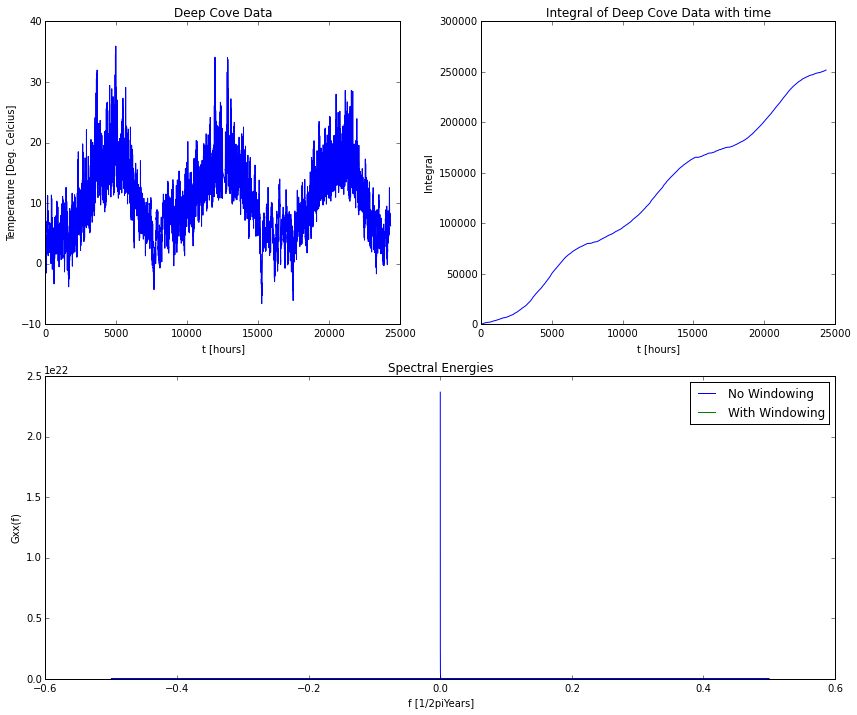

In [46]:
y = np.cumsum(dc)

# Raw Spectra
Y = dt*np.fft.fft(y)
GxxY= (2./T)*np.real(np.conj(Y[:N/2])*Y[:N/2])
freqGxxY = np.fft.fftfreq(len(GxxY),1.)

# Block averaging with 25% overlap Hanning windows
nfft = 512
nop = nfft/4
windowsY,freqWindowsY = mlab.psd(dc,NFFT=nfft,Fs=1./dt,window=mlab.window_hanning,noverlap=nop)

# Normalize the data
GxxNorm = (GxxY-np.mean(GxxY))/np.std(GxxY)
windowsNorm = (windowsY-np.mean(windowsY))/np.std(windowsY)

plt.figure(figsize=(12,10))
gs=gridspec.GridSpec(2,2)
ax1=plt.subplot(gs[0:1])
ax1.plot(t,dc)
ax1.set_title('Deep Cove Data')
ax1.set_xlabel('t [hours]')
ax1.set_ylabel('Temperature [Deg. Celcius]')

ax2=plt.subplot(gs[1:2])
ax2.plot(t,y)
ax2.set_title('Integral of Deep Cove Data with time')
ax2.set_xlabel('t [hours]')
ax2.set_ylabel('Integral')

ax3=plt.subplot(gs[2:4])
ax3.plot(freqGxxY,GxxY,label='No Windowing')
ax3.plot(freqWindowsY,windowsY,label='With Windowing')
ax3.set_title('Spectral Energies')
ax3.set_xlabel('f [1/2piYears]')
ax3.set_ylabel('Gxx(f)')
ax3.legend()

plt.tight_layout()

YOUR ANSWER HERE